# Naive Bayes & SVM

Most of the code is based on the scikit-learn documentation for [working with text data](http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html)

## Multinomial Naive Bayes

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

In [2]:
# Load data and convert FAKE/REAL to 0/1
kd = pd.read_csv('../data/fake_or_real_news.csv', index_col = 0)
kd['labelint'] = kd.label.map({'FAKE':0,'REAL':1})

In [3]:
# Split data into training and test sets
train, test = train_test_split(kd, test_size = 0.2, stratify = kd.labelint, random_state = 19)

In [4]:
# Tokenize, create tf-idf weighting, and fit Multinomial Naive Bayes as a pipeline
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
])

text_clf = text_clf.fit(train.text, train.labelint)

In [5]:
# Make predictions on test set and view accuracy
predicted = text_clf.predict(test.text)
metrics.accuracy_score(test.labelint, predicted) 

0.80978689818468819

## Linear SVM

In [6]:
# Fit SVM
text_clf = Pipeline([('vect', CountVectorizer(stop_words = 'english')),
                     ('tfidf', TfidfTransformer()),
                     ('clf', SGDClassifier(loss='hinge', penalty='l2',
                                           alpha=1e-3, n_iter=5, random_state=42)),
])
text_clf = text_clf.fit(train.text, train.labelint)

# Predict on test set
predicted = text_clf.predict(test.text)

# Accuracy
metrics.accuracy_score(test.labelint, predicted)

0.92344119968429361

In [7]:
# View more detailed metrics
print(metrics.classification_report(test.labelint, predicted))

             precision    recall  f1-score   support

          0       0.90      0.95      0.93       633
          1       0.95      0.89      0.92       634

avg / total       0.93      0.92      0.92      1267



In [8]:
# Confusion matrix
metrics.confusion_matrix(test.labelint, predicted)

array([[604,  29],
       [ 68, 566]])

## Tune SVM parameters with grid search

In [9]:
# Use grid search to tune parameters
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
              'tfidf__use_idf': (True, False),
              'clf__alpha': (1e-2, 1e-3, 1e-4),
}

In [10]:
gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1)

In [11]:
# Fit linear SVM with grid search optimization -- takes a little while
gs_clf = gs_clf.fit(train.text, train.labelint)

In [12]:
# View best parameters found in grid search
gs_clf.best_params_

{'clf__alpha': 0.0001, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 2)}

In [13]:
# View accuracy
gs_predicted = gs_clf.predict(test.text)
metrics.accuracy_score(test.labelint, gs_predicted)

0.95501183898973951

In [14]:
# More detailed metrics
print(metrics.classification_report(test.labelint, gs_predicted))

             precision    recall  f1-score   support

          0       0.95      0.96      0.96       633
          1       0.96      0.95      0.95       634

avg / total       0.96      0.96      0.96      1267



In [15]:
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline

/Users/Kara/anaconda/envs/infx575/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [16]:
# Confusion matrix
confusion = metrics.confusion_matrix(test.labelint, gs_predicted)
confusion

array([[606,  27],
       [ 30, 604]])

In [17]:
ann = np.array([["True negative: ", "False positive: "], ["False negative: ", "True positive: "]])
conf_string = np.char.mod('%d', confusion)
ann = np.core.defchararray.add(ann, conf_string)

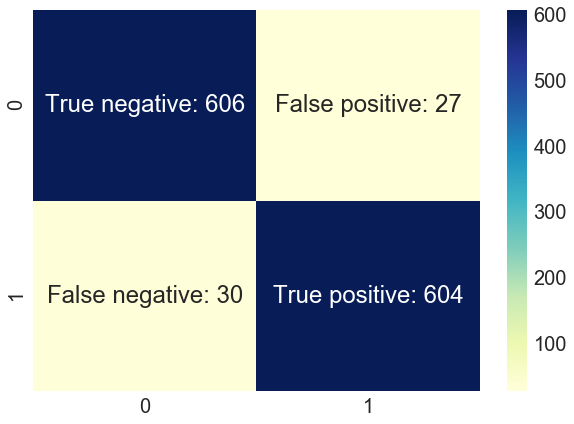

In [18]:
plt.figure(figsize = (10,7))

sn.set(font_scale=2)
sn.heatmap(confusion, annot=ann, fmt='', cmap="YlGnBu")

In [19]:
# Learning curve based on:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
 
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.grid("on")
    plt.legend(loc="best")
    return plt


In [20]:
# Create estimator with the parameters above
estimator = Pipeline([('vect', CountVectorizer(stop_words = 'english', ngram_range = (1, 2))),
             ('tfidf', TfidfTransformer()),
             ('clf', SGDClassifier(loss='hinge', penalty='l2',
                                   alpha=1e-4, n_iter=5, random_state=42)),
])

<module 'matplotlib.pyplot' from '/Users/Kara/anaconda/envs/infx575/lib/python3.6/site-packages/matplotlib/pyplot.py'>

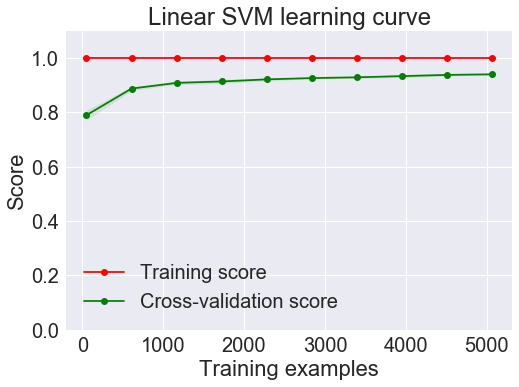

In [21]:
# Create learning curve
plot_learning_curve(estimator, "Linear SVM learning curve",
                    kd.text, kd.labelint, ylim=(0, 1.1), cv = 5,
                    train_sizes=np.linspace(.01, 1.0, 10), n_jobs = 4)

If/when we combine additional features (reading level, sentiment, etc.), we could add them to the SVM following [this tutorial](http://michelleful.github.io/code-blog/2015/06/20/pipelines/). Also relevant: https://datascience.stackexchange.com/a/991.

Some more helpful resources for working with sklearn pipelines:
- http://zacstewart.com/2014/08/05/pipelines-of-featureunions-of-pipelines.html
- https://github.com/michelleful/SingaporeRoadnameOrigins/blob/master/notebooks/04%20Adding%20features%20with%20Pipelines.ipynb

# Adding additional features

Let's use the [afinn](https://pypi.python.org/pypi/afinn/0.1) package to add sentiment as a feature in our data.

In [22]:
from afinn import Afinn
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin

afinn = Afinn()

In [23]:
# Create custom transformers

# Extract text from a column from https://github.com/zacstewart/kaggle_seeclickfix/blob/master/estimator.py
class TextExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def transform(self, data):
        return np.asarray(data[self.column]).astype(str)

    def fit(self, *_):
        return self

# Calculate sentiment of values in a column
class SentimentCalculator(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def sentiment_calc(self, text):        
        return afinn.score(text)

    def transform(self, data, y=None):
        sentiments = data[self.column].apply(self.sentiment_calc)
        return np.transpose(np.matrix(sentiments)) # Make sure data is the right
                                                   # shape to be combined with
                                                   # other features

    def fit(self, df, y=None):
        return self

In [24]:
# Sentiment feature    
sentiment_feat = Pipeline([
    ('sentiment', SentimentCalculator('text'))
])

# Tf-idf feature
tfidf_feat = Pipeline([
    ('text_extract', TextExtractor('text')),
    ('vect', CountVectorizer(stop_words = 'english', ngram_range = (1, 2))),
    ('tfidf', TfidfTransformer())
])

# Combine the features
combined_features = FeatureUnion([
  ('sentiment_features', sentiment_feat),
  ('tfidf_features', tfidf_feat)
])

# Create pipeline
pipeline = Pipeline([
    ('features', combined_features),
    ('clf', SGDClassifier(loss = 'hinge', penalty = 'l2',
                          alpha = 1e-4, n_iter = 5, random_state = 42))
])

In [25]:
# Fit model
pipeline_fitted = pipeline.fit(train, train.labelint)

In [26]:
# Make predictions
predicted = pipeline_fitted.predict(test)

In [27]:
# View accuracy
metrics.accuracy_score(test.labelint, predicted)

0.58168902920284138

Welp, adding the sentiment drastically worsened our model, so let's try optimizing again.

In [28]:
# Parameters to tune
# sorted(pipeline.get_params().keys()) # View possible parameter names
parameters = {'features__tfidf_features__vect__ngram_range': [(1, 1), (1, 2)],
              'features__tfidf_features__tfidf__use_idf': (True, False),
              'clf__alpha': (1e-2, 1e-3, 1e-4),
}

In [29]:
gs_pipeline_fitted = GridSearchCV(pipeline_fitted, parameters, n_jobs=-1)

In [30]:
# Fit with grid search (slowww)
gs_pipeline_fitted = gs_pipeline_fitted.fit(train, train.labelint)

In [31]:
# View best parameters
gs_pipeline_fitted.best_params_

{'clf__alpha': 0.0001,
 'features__tfidf_features__tfidf__use_idf': False,
 'features__tfidf_features__vect__ngram_range': (1, 2)}

In [32]:
# Predict on test set
gs_pipeline_predicted = gs_pipeline_fitted.predict(test)

In [33]:
# View accuracy score
metrics.accuracy_score(gs_pipeline_predicted, test.labelint)

0.65272296764009474